In [1]:
import sys
sys.path.append("staubli")
import staubli.utils as su
from staubli.stlprocessing import *
import staubli.visualize as sv
import staubli.automation as sa
from staubli.project import StaubliProject
import time


config, printing = sa.load_validate_configs(schemaPath="staubli/", jsonPath="valveTest/")
valve = StlMesh(config["stlPath"])
globalScale = valve.mesh.vertices.copy().flatten()

In [2]:
import numpy as np
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import utils as su
import matplotlib.patches as mpatches

def get_color(i):
    colors = ["blue", "black", "red", "green", "orange", "yellow", "gray"]
    return colors[i%7]

def matplot_valve(axes, valve):
    maxVal, minVal = -10000000, 1000000
    patches = []
    for i in range(len(valve.submeshes)):
        submesh = valve.submeshes[i]
        submesh.mesh.unmerge_vertices()
        polys = submesh.mesh.vertices.copy().reshape(-1,3,3)
        axes.add_collection3d(mplot3d.art3d.Poly3DCollection(polys, alpha=0.7,\
                                                             facecolors=get_color(i)))
    
        patches.append(mpatches.Patch(color=get_color(i), label="submesh {0}".format(i)))
        maxVal = max(maxVal, submesh.mesh.vertices.max())
        minVal = min(minVal, submesh.mesh.vertices.min())
    
        submesh.mesh.merge_vertices()
    
    scale = [minVal,maxVal]
    axes.auto_scale_xyz(scale, scale, scale)
    #axes.legend(handles=patches)

def matplot_mesh(axes, submesh, plotInt=False, addZAxis=True, c="blue"):
    # Load the STL files and add the vectors to the plot
    submesh.mesh.unmerge_vertices()
    polys = submesh.mesh.vertices.copy().reshape(-1,3,3)
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(polys, alpha=0.7, facecolors=c))
    
    # Auto scale to the mesh size,
    scale = submesh.mesh.vertices
    
    if(addZAxis):
        axes.plot([0,0],[0,0],[-10,10],c="black")
    
    
    centroids = np.array([su.get_face_centroid(submesh.mesh,i) for i in range(len(submesh.mesh.face_normals))])
    
    if(plotInt):
        X, Y, Z = submesh.intPoints[:,0], submesh.intPoints[:,1], submesh.intPoints[:,2]
        U, V, W = submesh.intNormals[:,0], submesh.intNormals[:,1], submesh.intNormals[:,2]
        axes.plot(X,Y,Z,c='r')
    else: 
        X, Y, Z = centroids[:,0], centroids[:,1], centroids[:,2]
        U, V, W = submesh.mesh.face_normals[:,0], submesh.mesh.face_normals[:,1], submesh.mesh.face_normals[:,2]
    
    s = 1
    #axes.scatter(X*s,Y*s,Z*s,c='r')
    #axes.quiver(X*s, Y*s, Z*s, U, V, W)
    
    axes.auto_scale_xyz(scale[:,0], scale[:,0], scale[:,0])
    submesh.mesh.merge_vertices()


<IPython.core.display.Javascript object>


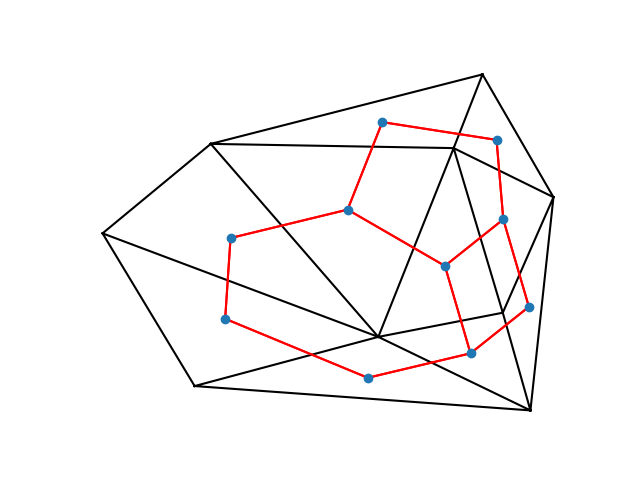

In [250]:
%matplotlib notebook
figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)

np.random.seed(10)
points=np.random.rand(9, 2)

tri=scipy.spatial.Delaunay(points)
axes.triplot(points[:,0],points[:,1],tri.simplices.copy(),'k-',
            label='Delaunay\ntriangulation')
tN = len(tri.simplices.copy())
mids = np.zeros((tN,2))
for i in range(tN):
    for j in tri.simplices.copy()[i]:
        mids[i] += points[j]
    mids[i]/=3

for i in range(tN):
    for n in tri.neighbors[i]:
        if(n != -1):
            axes.plot([mids[i,0],mids[n,0]],[mids[i,1],mids[n,1]], c="r")

axes.scatter(mids[:,0], mids[:,1],zorder=10)
axes.set_axis_off()
plt.savefig("triangleGraph.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=150)
#plt.show()

<IPython.core.display.Javascript object>


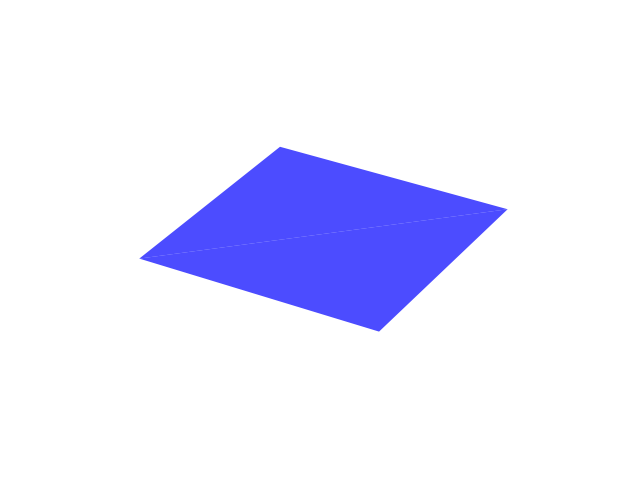

In [82]:
figure = plt.figure(frameon=False)
axes = mplot3d.Axes3D(figure,auto_add_to_figure=False)
figure.add_axes(axes)
matplot_valve(axes, valve)
axes.set_axis_off()
axes.auto_scale_xyz(globalScale, globalScale, globalScale)
#plt.savefig("step1.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=100)

<IPython.core.display.Javascript object>


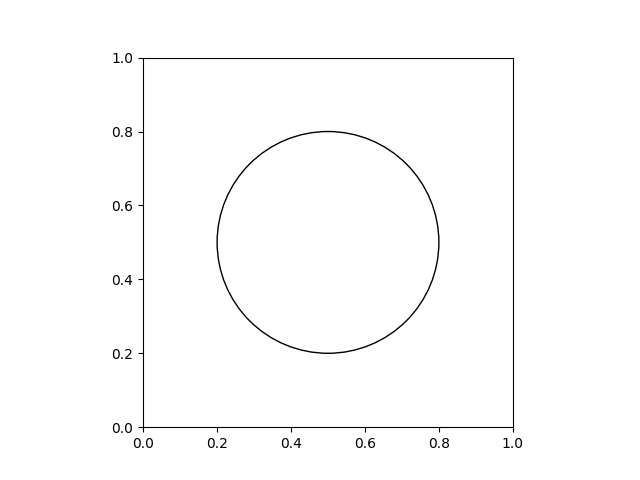

In [127]:
%matplotlib notebook

figure, axes = plt.subplots()

draw_circle = plt.Circle((0.5, 0.5), 0.3,fill=False)

axes.set_aspect(1)
axes.add_artist(draw_circle)

<IPython.core.display.Javascript object>


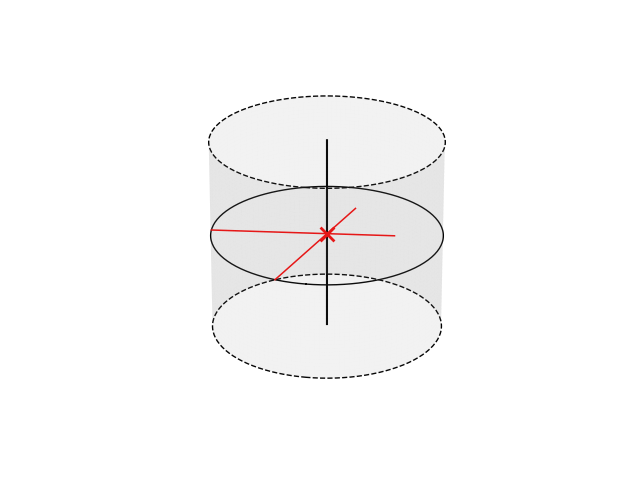

<ipython-input-150-9e9b53947aa8>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


In [150]:
%matplotlib notebook
subleaf = valve.submeshes[3]
subleaf.transform_to_projection()


figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Cylinder
r = 8.6
x=np.linspace(-r, r, 100)
z=np.linspace(-10, 10, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(r**2-Xc**2)

axes.plot_surface(Xc, Yc, Zc, alpha=0.1, color="gray", shade=False)
axes.plot_surface(Xc, -Yc, Zc, alpha=0.1, color="gray", shade=False)

theta = np.linspace(0, 2 * np.pi, 201)
y = r*np.cos(theta)
x = r*np.sin(theta)
z = np.ones(len(theta))
axes.plot(x,y,z*-10, "k--",linewidth=1)
axes.plot(x,y,z*10, "k--",linewidth=1)
axes.plot(x,y,z*0, "k",linewidth=1)

#rays
fac=8.6
fac2=15
def get_ray_cylindric(p):
    q1 = [np.cos(-p[0])*fac,np.sin(-p[0])*fac,p[1]]
    q2 = [0,0,p[1]]
    
    return np.array([q1,q2])

def get_ray_cylindric2(p):
    q1 = [np.cos(-p[0])*fac2,np.sin(-p[0])*fac2,p[1]]
    q2 = [np.cos(-p[0])*fac,np.sin(-p[0])*fac,p[1]]
    
    return np.array([q1,q2])

for p in grid[mask]:
    ray = get_ray_cylindric(p)
    #axes.plot([ray[0,0],ray[1,0]],[ray[0,1],ray[1,1]], [ray[0,2],ray[1,2]], c="red", linewidth=1)
    ray = get_ray_cylindric2(p)
    #axes.plot([ray[0,0],ray[1,0]],[ray[0,1],ray[1,1]], [ray[0,2],ray[1,2]], c="red", linestyle="dotted", linewidth=1)
    #axes.scatter([ray[1,0]],[ray[1,1]], [ray[1,2]], c="red",marker="x" )

#for p in grid[mask]:
#    axes.plot([p[0],p[0]],[p[1],p[1]], [0,10], c="red", linewidth=1)
#    axes.plot([p[0],p[0]],[p[1],p[1]], [-10,0], c="red", linewidth=1,linestyle="dotted")
#    axes.scatter([p[0]], [p[1]], 0, c="red",marker="x")


axes.plot([0,0],[0,0],[-10,10],c="black")
alpha, beta = 0.1, 1.3
r,r2 = 8.6, -5
axes.plot([np.cos(alpha)*r,np.cos(alpha)*r2],[np.sin(alpha)*r,np.sin(alpha)*r2],[0,0], c="r", linewidth=1.1)
axes.plot([np.cos(beta)*r,np.cos(beta)*r2],[np.sin(beta)*r,np.sin(beta)*r2],[0,0], c="r",  linewidth=1.1)
axes.scatter([0], [0], 0, c="red",marker="x", s=100,linewidth=2)

#matplot_mesh(axes, subleaf,c="green")
axes.set_axis_off()
axes.auto_scale_xyz(globalScale, globalScale, globalScale)
axes.view_init(elev=25, azim=100)
#plt.savefig("symmetry_point.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=100)

In [49]:
    
def plot_convex_hull(axes, submesh):
    hullPoints = submesh.p_points[submesh.p_hull.vertices]
    zs = 3
    offs = 20
    centroids = np.array([su.proj_cylindric(su.get_face_centroid(submesh.mesh,i)) for i in range(len(submesh.mesh.face_normals))])
    for i in range(len(centroids)):
        if(centroids[i,0] < 0.1):
            centroids[i,0] = 0.1
    axes.scatter(centroids[:,0], centroids[:,1]*zs+offs, alpha=1, s=6,c="b")
    axes.scatter(submesh.p_points[:,0], submesh.p_points[:,1]*zs+offs, alpha=1, s=6,c="b")
    axes.plot(np.concatenate([hullPoints[:,0],[hullPoints[0,0]]]),\
              np.concatenate([hullPoints[:,1]*zs+offs,[hullPoints[0,1]*zs+offs]]), 'r', lw=2)
    axes.set_ylabel('Distance in z-Direction [mm]', size=18)
    axes.set_xlabel('Angle to x-Axis [rad]', size=18)
    
def plot_points_hull(axes, submesh, grid):
    mask = su.points_in_hull(grid, submesh.p_hull)
    hullPoints = submesh.p_points[submesh.p_hull.vertices]
    
    zs = 3

    axes.plot(np.concatenate([hullPoints[:,0],[hullPoints[0,0]]]),\
              np.concatenate([hullPoints[:,1]*zs,[hullPoints[0,1]*zs]]), 'r', lw=2)
    axes.plot(grid[:,0], grid[:,1]*zs)
    axes.scatter(grid[mask,0], grid[mask,1]*zs, c='g', marker="x")
    mask = np.logical_not(mask)
    axes.scatter(grid[mask,0], grid[mask,1]*zs, c='b')
    axes.set_ylabel('Distance in z-Direction [mm]', size=18)
    axes.set_xlabel('Angle to x-Axis [rad]', size=18)

<IPython.core.display.Javascript object>


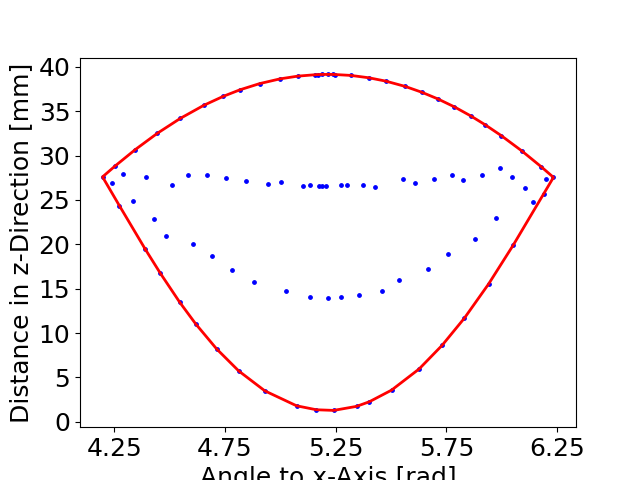

In [53]:
%matplotlib notebook
subleaf = valve.submeshes[0]
subleaf.transform_to_projection()
figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)
plot_convex_hull(axes,subleaf)
plt.xticks([4.25,4.75,5.25,5.75,6.25],fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("convexHullLeaf.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=100)

<IPython.core.display.Javascript object>


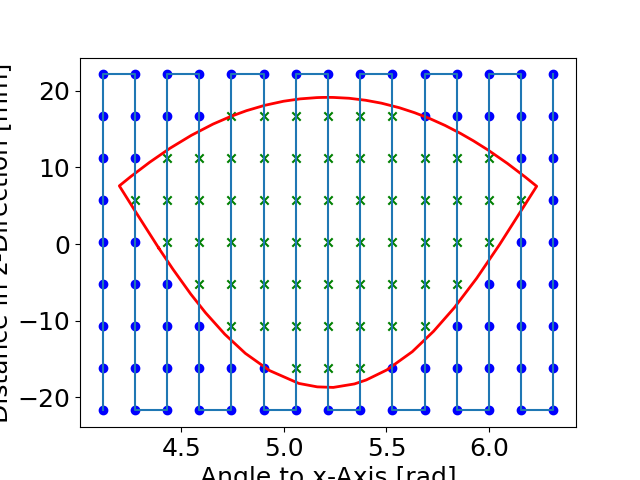

In [41]:
%matplotlib notebook
figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)

pointsConfig = printing["submeshPrinting"][0]["points"]
dy = 2

if subleaf.surfaceForm == SurfaceForm.Flat:
    dx = dy
else:
    dx = dy/subleaf.radius

edges= 0.5
    
if(pointsConfig["pattern"] == "topDown"):
    grid = su.topDownGrid(subleaf.p_xmin-dx*edges, subleaf.p_ymin-dy*edges,\
                     subleaf.p_xmax+dx*edges, subleaf.p_ymax+dy*edges, dx,dy)
else: 
    grid = su.topDownGrid(subleaf.p_xmin-dx*edges, subleaf.p_ymin-dy*edges,\
                      subleaf.p_xmax+dx*edges, subleaf.p_ymax+dy*edges, dx,dy).T

mask = su.points_in_hull(grid, subleaf.p_hull)

plot_points_hull(axes, subleaf, grid)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#axes.set_axis_off()
#plt.arrow(-1.5,-7,1,0, head_width=0.5, head_length=0.2, fc='k', ec='k')
#plt.arrow(-1.5,-7,0,3, head_width=0.17, head_length=0.6, fc='k', ec='k')
plt.savefig("pointGenerationLeaf.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=100)

In [8]:
start = time.time()

subleaf.transform_to_projection()
subleaf.set_proj_points_normals(grid[mask])

end = time.time()
print(end - start)

1.4257745742797852


<IPython.core.display.Javascript object>


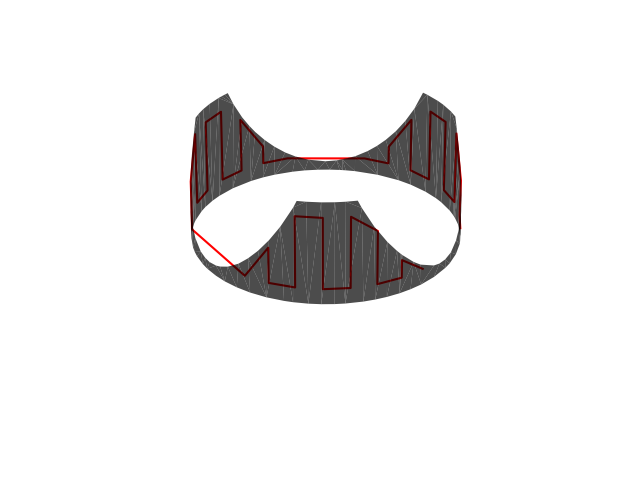

In [9]:
%matplotlib notebook
figure = plt.figure()
axes = mplot3d.Axes3D(figure,auto_add_to_figure=False)
figure.add_axes(axes)
subleaf.transform_to_original()
matplot_mesh(axes, subleaf, True, False, "black")

axes.auto_scale_xyz(globalScale, globalScale, globalScale)
axes.set_axis_off()
#plt.savefig("step4.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=100)

In [213]:
config, printing = sa.load_validate_configs(schemaPath="staubli/", jsonPath="valveTest/")
for i in range(len(valve.submeshes)):
    subleaf = valve.submeshes[i]

    pointsConfig = printing["submeshPrinting"][i]["points"]
    dy = pointsConfig["distance"]
    
    if subleaf.surfaceForm == SurfaceForm.Flat:
        dx = dy
    else:
        dx = dy/subleaf.radius
        
    if(pointsConfig["pattern"] == "topDown"):
        grid = su.topDownGrid(subleaf.p_xmin-dx, subleaf.p_ymin-dy,\
                         subleaf.p_xmax+dx, subleaf.p_ymax+dy, dx,dy)
    else: 
        grid = su.topDownGrid(subleaf.p_xmin-dx, subleaf.p_ymin-dy,\
                          subleaf.p_xmax+dx, subleaf.p_ymax+dy, dx,dy).T
    
    mask = su.points_in_hull(grid, subleaf.p_hull)



    start = time.time()

    subleaf.transform_to_projection()
    subleaf.set_proj_points_normals(grid[mask])

    end = time.time()
    print(end - start)

0.10077118873596191
2.3107151985168457
0.08709073066711426
0.07611823081970215


<IPython.core.display.Javascript object>


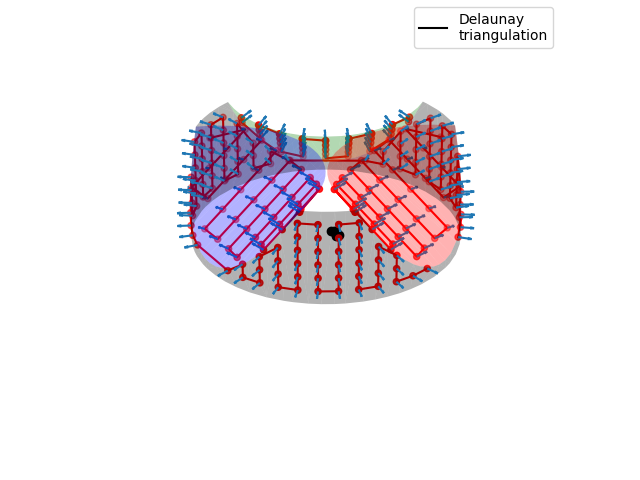

In [216]:
%matplotlib notebook
# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure,auto_add_to_figure=False)
figure.add_axes(axes)
colors = ["blue", "black", "red", "green", "orange", "yellow", "gray"]
for i in range(len(valve.submeshes)):
    subleaf = valve.submeshes[i]
    subleaf.transform_to_original()
    matplot_mesh(axes, subleaf, True, False, colors[i])

axes.auto_scale_xyz(globalScale, globalScale, globalScale)
axes.set_axis_off()
plt.savefig("step4.png", transparent=True, bbox_inches='tight', pad_inches=0,dpi=100)